# Juliaではじめる会計でーたさいえんす　第2回
本稿は、新井康平先生のRのコード( https://twitter.com/araikohei_osaka/status/1269175335343415301?s=20 )を元に書かれたものです。元の『企業会計』7月号の「Pythonではじめる会計データサイエンス」(第2回)については、私が海外にいるため、参照できておりません。（電子版を購読しましたが、8月までアップされないそうです。）この点、ご諒承下さい。ここでは、Jupyter Notebook/LabからJuliaを利用することを前提にしています。Juliaのインストール方法やJupyterとの連携方法、既にPythonとJupyterがインストールされている状況でのJuliaのインストール方法…はググって下さい。なお、ここでのコードの動作確認は、Julia 1.4.1で行っております。古いバージョン（特に1.0未満）だと動かない可能性があるので、ご注意下さい。

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#パッケージの読み込み" data-toc-modified-id="パッケージの読み込み-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>パッケージの読み込み</a></span></li><li><span><a href="#データセットの取得と読込" data-toc-modified-id="データセットの取得と読込-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>データセットの取得と読込</a></span></li><li><span><a href="#データセットの加工" data-toc-modified-id="データセットの加工-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>データセットの加工</a></span><ul class="toc-item"><li><span><a href="#データの型の確認" data-toc-modified-id="データの型の確認-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>データの型の確認</a></span></li><li><span><a href="#日付データの加工" data-toc-modified-id="日付データの加工-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>日付データの加工</a></span></li><li><span><a href="#日次・店舗毎のデータを月次ベースのデータに変換" data-toc-modified-id="日次・店舗毎のデータを月次ベースのデータに変換-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>日次・店舗毎のデータを月次ベースのデータに変換</a></span></li><li><span><a href="#月間売上高のグラフの作成" data-toc-modified-id="月間売上高のグラフの作成-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>月間売上高のグラフの作成</a></span></li></ul></li><li><span><a href="#ポアソン分布の作成" data-toc-modified-id="ポアソン分布の作成-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ポアソン分布の作成</a></span></li><li><span><a href="#属性サンプリング" data-toc-modified-id="属性サンプリング-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>属性サンプリング</a></span></li><li><span><a href="#金額単位サンプリング" data-toc-modified-id="金額単位サンプリング-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>金額単位サンプリング</a></span><ul class="toc-item"><li><span><a href="#データセットの読み込み" data-toc-modified-id="データセットの読み込み-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>データセットの読み込み</a></span></li><li><span><a href="#各種パラメータの設定等" data-toc-modified-id="各種パラメータの設定等-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>各種パラメータの設定等</a></span></li><li><span><a href="#ランダムに並び替え" data-toc-modified-id="ランダムに並び替え-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>ランダムに並び替え</a></span></li><li><span><a href="#グルーピング変数の作成" data-toc-modified-id="グルーピング変数の作成-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>グルーピング変数の作成</a></span></li><li><span><a href="#各グループ区間の先頭サンプルの抽出" data-toc-modified-id="各グループ区間の先頭サンプルの抽出-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>各グループ区間の先頭サンプルの抽出</a></span></li></ul></li></ul></div>

## パッケージの読み込み
下記のパッケージを全て使用します。

In [1]:
using CSV, DataFrames, Dates, Plots, StatsPlots, Distributions, Random

インストールされていない場合は、下記の要領でインストールした上で、上記のコードを実行してください。Juliaの特性上（プリコンパイルが必要）、初回読込時は時間がかかりますのでご注意下さい。

    using Pkg
    Pkg.add("CSV")
    ...

## データセットの取得と読込
中央経済社のホームページから、uriage_sample.csvを取得し、これを読み込みます。エンコードの指定は、私の環境(Mac英語版)では不要でした。

In [2]:
df_sales = CSV.read(download("http://www.chuokeizai.co.jp/acc/202007/uriage_sample.csv"))
first(df_sales,5)   # 先頭5行表示

,店舗名,日付,売上金額
,String,String,Int64
1,東京駅,2018/1/1,0
2,東京駅,2018/1/2,0
3,東京駅,2018/1/3,0
4,東京駅,2018/1/4,0
5,東京駅,2018/1/5,0


## データセットの加工
### データの型の確認

In [3]:
typeof(df_sales)         # データ全体

DataFrame

In [4]:
describe(df_sales)       # 各列の詳細

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,店舗名,,吉祥寺,,葛西,5,,String
2,日付,,2018/1/1,,2019/9/9,730,,String
3,売上金額,153234.0,0,157130.0,620334,,,Int64


各列のデータの型のみを確認する方法（Rのsapply(..., class)に相当する方法）を私は知りませんが、次のような関数を作ることで同等の結果を得ることができます。簡単な関数なので1行で書けます。

In [5]:
sapply_class(df) = [names(df) eltype.(eachcol(df))]
sapply_class(df_sales)

3×2 Array{Any,2}:
 "店舗名"   String
 "日付"    String
 "売上金額"  Int64

### 日付データの加工
先ほど確認したように、現状では日付データが単なる文字列(String)として認識されてしまっているので、これを日付データとして認識させます。ここで重要なことですが、Juliaでは、列（列ベクトル）の要素全てに対して操作を実行する時には、下記（「Date.(df_sales.日付, "yyyy/mm/dd")」）のようにドットを入れる必要があります。これを「Date(df_sales.日付, "yyyy/mm/dd")」とするとエラーになります。

In [6]:
df_sales.日付 = Date.(df_sales.日付, "yyyy/mm/dd")

3650-element Array{Date,1}:
 2018-01-01
 2018-01-02
 2018-01-03
 2018-01-04
 2018-01-05
 2018-01-06
 2018-01-07
 2018-01-08
 2018-01-09
 2018-01-10
 2018-01-11
 2018-01-12
 2018-01-13
 ⋮
 2019-12-20
 2019-12-21
 2019-12-22
 2019-12-23
 2019-12-24
 2019-12-25
 2019-12-26
 2019-12-27
 2019-12-28
 2019-12-29
 2019-12-30
 2019-12-31

さらに、年月日を年、月、日にちに分け、対応する曜日を追加します。Juliaでは、Dates関数を使うことで、年月日データから年だけ、月だけ…を抽出することができます。列の要素に対する操作なので、ドットを忘れないように。

In [7]:
df_sales.年 = Dates.year.(df_sales.日付)
df_sales.月 = Dates.month.(df_sales.日付)
df_sales.日 = Dates.day.(df_sales.日付)
df_sales.曜日 = Dates.dayname.(df_sales.日付)
first(df_sales,10)

,店舗名,日付,売上金額,年,月,日,曜日
,String,Date,Int64,Int64,Int64,Int64,String
1,東京駅,2018-01-01,0,2018,1,1,Monday
2,東京駅,2018-01-02,0,2018,1,2,Tuesday
3,東京駅,2018-01-03,0,2018,1,3,Wednesday
4,東京駅,2018-01-04,0,2018,1,4,Thursday
5,東京駅,2018-01-05,0,2018,1,5,Friday
6,東京駅,2018-01-06,0,2018,1,6,Saturday
7,東京駅,2018-01-07,0,2018,1,7,Sunday
8,東京駅,2018-01-08,269516,2018,1,8,Monday
9,東京駅,2018-01-09,255962,2018,1,9,Tuesday


### 日次・店舗毎のデータを月次ベースのデータに変換

In [8]:
df_monthly_sales = combine(groupby(df_sales, [:年,:月]), :売上金額 => sum => :月間売上高)

,年,月,月間売上高
,Int64,Int64,Int64
1,2018,1,18792230
2,2018,2,18661016
3,2018,3,29675302
4,2018,4,32267984
5,2018,5,18812765
6,2018,6,19656198
7,2018,7,18115961
8,2018,8,16360073
9,2018,9,20645062


### 月間売上高のグラフの作成

データフレームからグラフを作成する場合には、通常のPlotsに加えてStatsPlotsを用いると便利です。ここでは、最初のコードで読み込まれています。

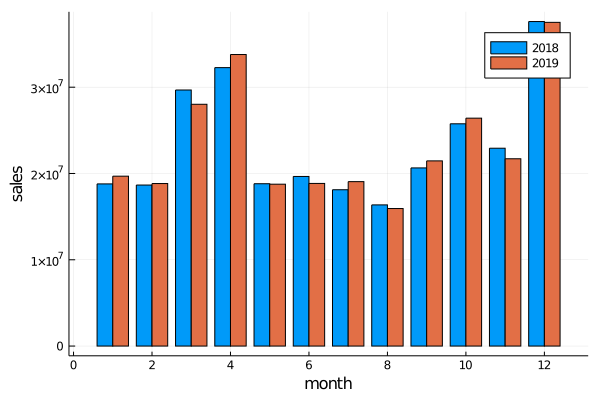

In [9]:
@df df_monthly_sales groupedbar(:月, :月間売上高, group = :年, xlabel = "month", ylabel = "sales")

## ポアソン分布の作成

ここでは、Distributionパッケージを使用します。Poisson($\lambda$)やBinomial(n,p)で確率変数の分布を指定し、pdf関数を用いることで、その確率変数が特定の値をとる確率(注：本稿では離散値をとるケースなのでこのような表現になっています)を算出することができます。

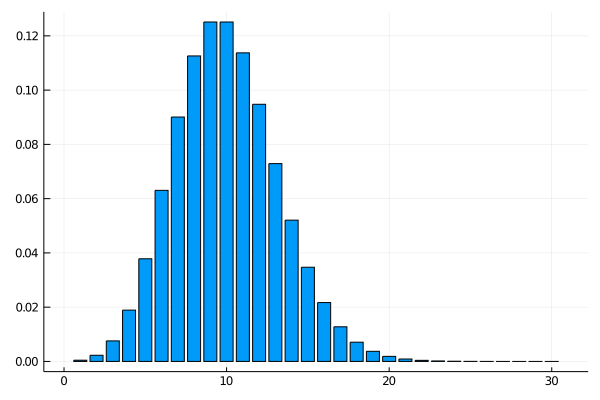

In [10]:
k    = 1:30
lamb = 10
bar(pdf.(Poisson(lamb),k), label = false)

## 属性サンプリング

In [11]:
pt    = 0.1
alpha = 0.05
ke    = 0

i = 0
while pdf(Binomial(i, pt), ke) > alpha
    println(i)
    i = i + 1
end
i # 29になる

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


29

## 金額単位サンプリング
### データセットの読み込み
ここでは、CSVファイルにヘッダー情報が書かれていないので、こちらで指定しています。特に指定しない場合は、「header = false」としても構いません。2行目では、桁区切りのコンマを取り除き、さらに文字列として認識されているデータを整数(integer)データに変換しています。

In [12]:
df_receivable = CSV.read(download("http://www.chuokeizai.co.jp/acc/202007/sample-receivable.csv"), header=[:会社名,:金額])
df_receivable.am = parse.(Int, replace.(df_receivable.金額, "," => ""))
first(df_receivable, 5)

,会社名,金額,am
,String,String,Int64
1,株式会社0001,"14,980,000",14980000
2,株式会社0002,"19,030,000",19030000
3,株式会社0003,"10,530,000",10530000
4,株式会社0004,"19,770,000",19770000
5,株式会社0005,"8,210,000",8210000


In [13]:
describe(df_receivable)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,会社名,,株式会社0001,,株式会社0300,300,,String
2,金額,,0,,"980,000",140,,String
3,am,2.5363e6,0,350000.0,29650000,,,Int64


### 各種パラメータの設定等

In [14]:
# 母集団における合計金額
N = sum(df_receivable.am)

# 重要性の基準値
pm = 40000000

# 予想虚偽表示金額
ke    = 0
alpha = 0.05

i = 0
while pdf(Binomial(i, pm/N), ke) > alpha
    println(i)
    i += 1  # 「i = i + 1」の省略版です。
end
i # 56になる

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


56

### ランダムに並び替え

In [15]:
Random.seed!(0)  # 乱数固定
df_shuffled = df_receivable[shuffle(1:size(df_receivable)[1]),:]

## 累積売上高の計算
df_shuffled.cumsum = cumsum(df_shuffled.am)
first(df_shuffled,5)

,会社名,金額,am,cumsum
,String,String,Int64,Int64
1,株式会社0270,"380,000",380000,380000
2,株式会社0149,"270,000",270000,650000
3,株式会社0299,"230,000",230000,880000
4,株式会社0165,"140,000",140000,1020000
5,株式会社0047,"1,040,000",1040000,2060000


### グルーピング変数の作成
Juliaにおいては、「÷」は整数剰の演算子です（一方、「/」は通常の除算です）。列ベクトルの要素に対する操作ですので、ドットを忘れないで下さい。なお、「div.(df_shuffled.cumsum, agg)」と書いても動作は同じです。

In [16]:
agg = N / i
df_shuffled.group = Int.(df_shuffled.cumsum .÷ agg) # ここではさらにInt関数で整数化しています。

300-element Array{Int64,1}:
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  1
  ⋮
 54
 54
 54
 54
 54
 54
 54
 54
 54
 55
 55
 55

### 各グループ区間の先頭サンプルの抽出

In [17]:
df_sample = groupby(df_shuffled, :group)
df_sample = combine(df_sample, valuecols(df_sample) .=> first .=> valuecols(df_sample))

,group,会社名,金額,am,cumsum
,Int64,String,String,Int64,Int64
1,0,株式会社0270,"380,000",380000,380000
2,1,株式会社0015,"13,260,000",13260000,25490000
3,2,株式会社0051,"5,500,000",5500000,30990000
4,3,株式会社0092,"6,770,000",6770000,42690000
5,4,株式会社0056,"8,040,000",8040000,56860000
6,5,株式会社0014,"17,960,000",17960000,75100000
7,6,株式会社0022,"6,920,000",6920000,87810000
8,7,株式会社0067,"7,440,000",7440000,95330000
9,8,株式会社0041,"8,740,000",8740000,112940000


In [18]:
size(df_sample)[1] # サンプルサイズの確認

48